In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
with open('names.txt') as f:
    words = f.read().splitlines()
print(len(words), words[:5])

32033 ['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [3]:
# Build the vocabulary of characters
SPECIAL_CHAR = '.'
vocab = [SPECIAL_CHAR] + sorted(list(set(''.join(words))))
VOCAB_SIZE = len(vocab)

itoc = {i:c for i, c in enumerate(vocab)}
ctoi = {c:i for i, c in itoc.items()}
print(VOCAB_SIZE, ctoi)

27 {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [4]:
# Dataset
CONTEXT_SIZE = 5

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [ctoi[SPECIAL_CHAR]] * CONTEXT_SIZE
        for ch in w + SPECIAL_CHAR:
            idx = ctoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [5]:
# Parameters
EMB_DIM = 10
hidden_dim = 200
g = torch.Generator().manual_seed(2147483647) # For reproducability
C = torch.randn(VOCAB_SIZE, EMB_DIM,                 generator=g) * 0.1
W1 = torch.randn(CONTEXT_SIZE * EMB_DIM, hidden_dim, generator=g) * (5/3) / (CONTEXT_SIZE * EMB_DIM) ** 0.5 # Kaiming initialization
# b1 = torch.randn(hidden_dim,                         generator=g) * 0.01
W2 = torch.randn(hidden_dim, VOCAB_SIZE,             generator=g) * 0.01
b2 = torch.randn(VOCAB_SIZE,                         generator=g) * 0.0

bngain = torch.ones(1, hidden_dim)
bnbias = torch.zeros(1, hidden_dim)
bnmean_running = torch.zeros(1, hidden_dim)
bnstd_running = torch.ones(1, hidden_dim) 

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # Total number of parameters
for p in parameters:
    p.requires_grad = True

16097


In [6]:
from statistics import fmean

BATCH_SIZE = 256 
max_steps = 200_000 
lossi = []

for i in range(max_steps):
    # Minibatch
    idx = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    emb = C[Xb]
    hpreact = emb.view(emb.shape[0], -1) @ W1 # + b1 # this bias gets cancelled out by batch normalization
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 1e-1 if i <= max_steps // 2 else 1e-2
    for p in parameters:
        p.data -= lr * p.grad

    # Track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1367
  20000/ 200000: 2.1595
  30000/ 200000: 2.0201
  40000/ 200000: 1.8276
  50000/ 200000: 1.9052
  60000/ 200000: 2.1240
  70000/ 200000: 1.9155
  80000/ 200000: 2.0087
  90000/ 200000: 1.9137
 100000/ 200000: 1.9003
 110000/ 200000: 1.9622
 120000/ 200000: 1.8305
 130000/ 200000: 1.8917
 140000/ 200000: 1.8087
 150000/ 200000: 1.9310
 160000/ 200000: 2.2237
 170000/ 200000: 2.0287
 180000/ 200000: 1.9594
 190000/ 200000: 2.0066


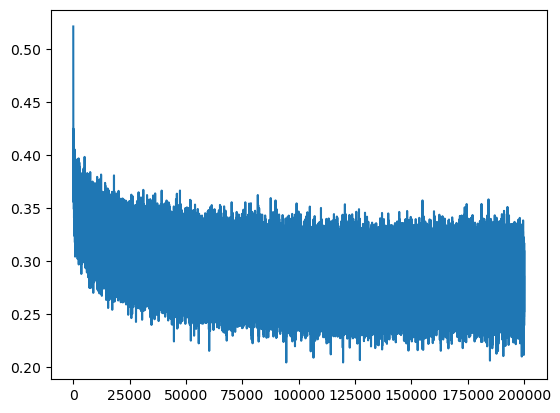

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[X]
    hpreact = emb.view(emb.shape[0], -1) @ W1 # + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running+ bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9069581031799316
val 2.0364909172058105


In [9]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * CONTEXT_SIZE
    while True:
        with torch.no_grad():
            emb = C[context]
            hpreact = emb.view(1, -1) @ W1 # + b1
            hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
            h = torch.tanh(hpreact)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs.detach(), num_samples=1, generator=g).item()
        if idx == 0:
            break
        out.append(idx)
        context = context[1:] + [idx]
    print(''.join(itoc[o] for o in out))

carmah
amelia
khirgha
rehty
skanson
jazziel
deliah
jarquiu
ramari
chaiir
kaleigh
hamor
catelinn
sulie
alivia
cortero
dearyn
kaiden
dustine
deciia


In [96]:
from typing import List
from torch import Tensor

class Linear:
    def __init__(self, fan_in:int, fan_out:int, bias:bool=True) -> None:
        self.weights = (torch.randn(fan_in, fan_out) / fan_in**0.5).requires_grad_()
        self.bias = torch.zeros(fan_out, requires_grad=True) if bias else None
    
    def __call__(self, x:Tensor) -> Tensor:
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self) -> List[Tensor]:
        return [self.weights] + [self.bias] if self.bias is not None else []
    

class BatchNorm1d:
    def __init__(self, dim:int, eps:float=1e-05, momentum:float=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters
        self.gamma = torch.ones(dim, requires_grad=True)
        self.beta = torch.zeros(dim, requires_grad=True)
        # Buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x) -> Tensor:
        # Forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdims=True)
            xvar = x.var(dim=0, keepdims=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var 
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize
        self.out = self.gamma * xhat + self.beta
        # Update buffer
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self) -> List[Tensor]:
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x) -> Tensor:
        self.out =  torch.tanh(x)
        return self.out

    def parameters(self) -> List:
        return []

EMB_DIM = 10 # the dimensionality of the character embedding vectors
hidden_dim = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn(VOCAB_SIZE, EMB_DIM, requires_grad=True, generator=g)
layers = [
    Linear(CONTEXT_SIZE * EMB_DIM, hidden_dim), BatchNorm1d(hidden_dim), Tanh(),
    Linear(hidden_dim, hidden_dim),             BatchNorm1d(hidden_dim), Tanh(),
    Linear(hidden_dim, hidden_dim),             BatchNorm1d(hidden_dim), Tanh(),
    Linear(hidden_dim, hidden_dim),             BatchNorm1d(hidden_dim), Tanh(),
    Linear(hidden_dim, hidden_dim),             BatchNorm1d(hidden_dim), Tanh(),
    Linear(hidden_dim, VOCAB_SIZE),             BatchNorm1d(VOCAB_SIZE),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1 # Make logit layer less confident
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= (5 / 3) # Kaiming init gain for tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

49551


In [97]:
BATCH_SIZE = 256 
max_steps = 200_000 
lossi = []
ud = []

for i in range(max_steps):
    # Minibatch
    idx = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 1e-1 if i <= max_steps // 2 else 1e-2
    for p in parameters:
        p.data -= lr * p.grad

    # Track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i == 10000:
    #     break

      0/ 200000: 3.3003
  10000/ 200000: 2.1963
  20000/ 200000: 1.9225
  30000/ 200000: 1.8840
  40000/ 200000: 1.9005
  50000/ 200000: 1.7975
  60000/ 200000: 1.7969
  70000/ 200000: 1.8611
  80000/ 200000: 1.8466
  90000/ 200000: 1.7029
 100000/ 200000: 1.7395
 110000/ 200000: 1.9043
 120000/ 200000: 1.7313
 130000/ 200000: 1.6641
 140000/ 200000: 1.7246
 150000/ 200000: 1.6565
 160000/ 200000: 1.5557
 170000/ 200000: 1.8094
 180000/ 200000: 1.7539
 190000/ 200000: 1.6817


layer 2 (      Tanh): mean +0.00, std 0.67, saturated: 12.42%
layer 5 (      Tanh): mean -0.00, std 0.71, saturated: 17.22%
layer 8 (      Tanh): mean +0.01, std 0.76, saturated: 20.48%
layer 11 (      Tanh): mean +0.01, std 0.79, saturated: 22.44%
layer 14 (      Tanh): mean +0.01, std 0.84, saturated: 31.68%


Text(0.5, 1.0, 'Activation Distribution')

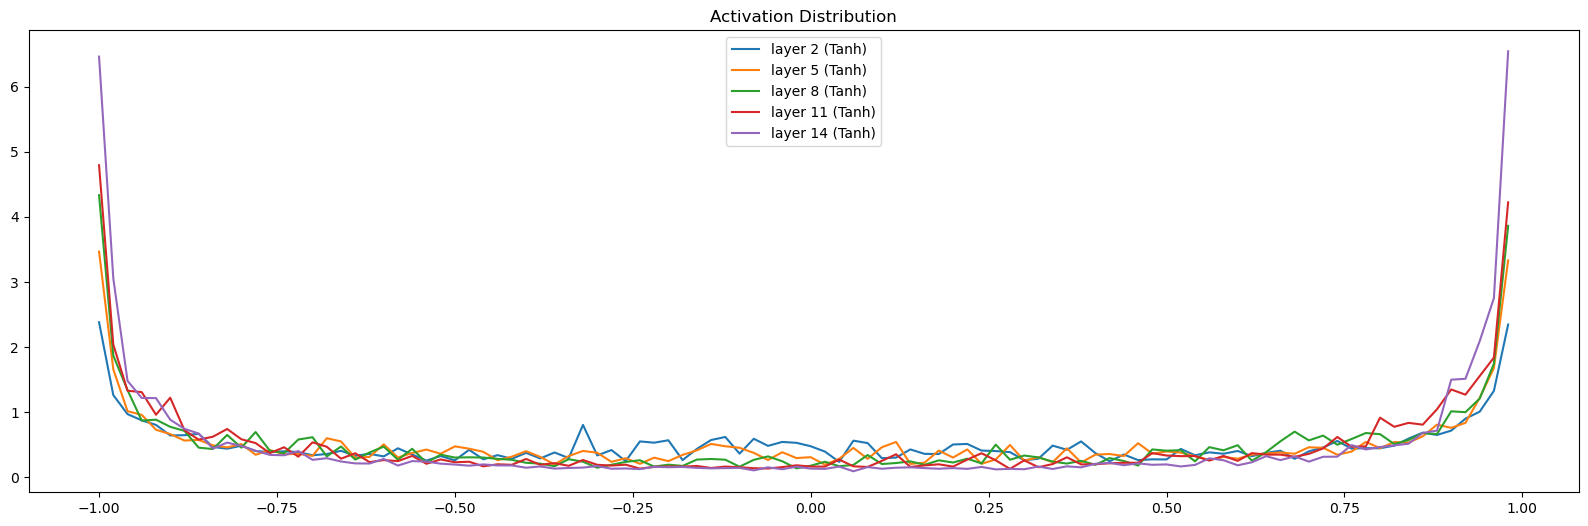

In [98]:
plt.figure(figsize=(20, 6))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        # print(t.shape)
        # print(t.mean().shape, t.std().shape)
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation Distribution')

layer 2 (      Tanh): mean +0.000000, std 1.907215e-03
layer 5 (      Tanh): mean +0.000000, std 1.567009e-03
layer 8 (      Tanh): mean +0.000000, std 1.306915e-03
layer 11 (      Tanh): mean -0.000000, std 1.164997e-03
layer 14 (      Tanh): mean -0.000000, std 1.173485e-03


Text(0.5, 1.0, 'gradient distribution')

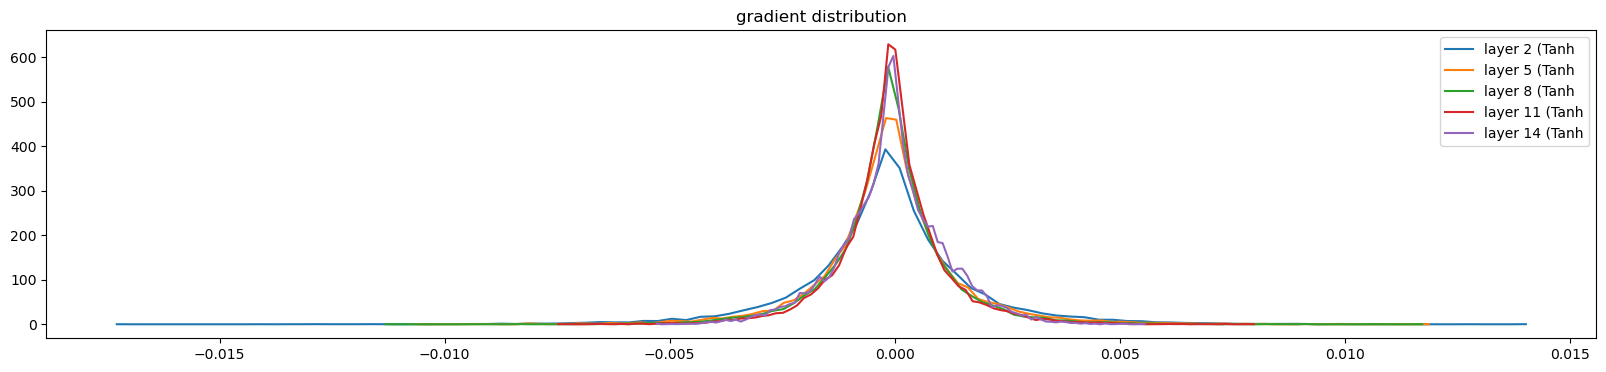

In [99]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.841107e-02 | grad:data ratio 1.739921e-02
weight  (50, 100) | mean +0.000094 | std 1.019487e-02 | grad:data ratio 3.067988e-02
weight (100, 100) | mean +0.000009 | std 8.042201e-03 | grad:data ratio 3.136353e-02
weight (100, 100) | mean +0.000032 | std 7.522645e-03 | grad:data ratio 2.999108e-02
weight (100, 100) | mean -0.000122 | std 6.879641e-03 | grad:data ratio 2.817920e-02
weight (100, 100) | mean -0.000037 | std 6.113015e-03 | grad:data ratio 2.584263e-02
weight  (100, 27) | mean +0.000083 | std 8.126008e-03 | grad:data ratio 2.642495e-02


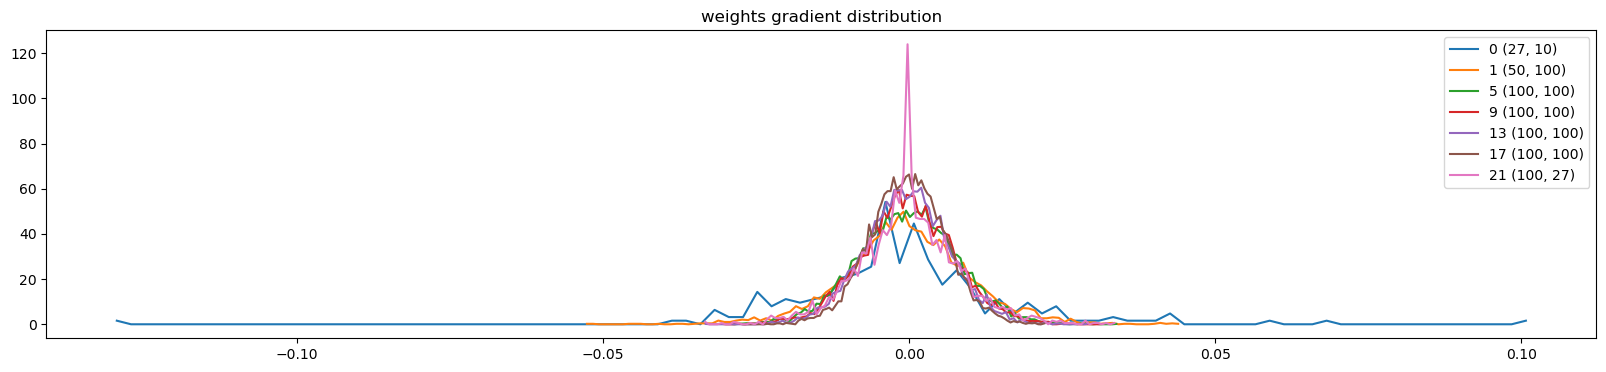

In [100]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

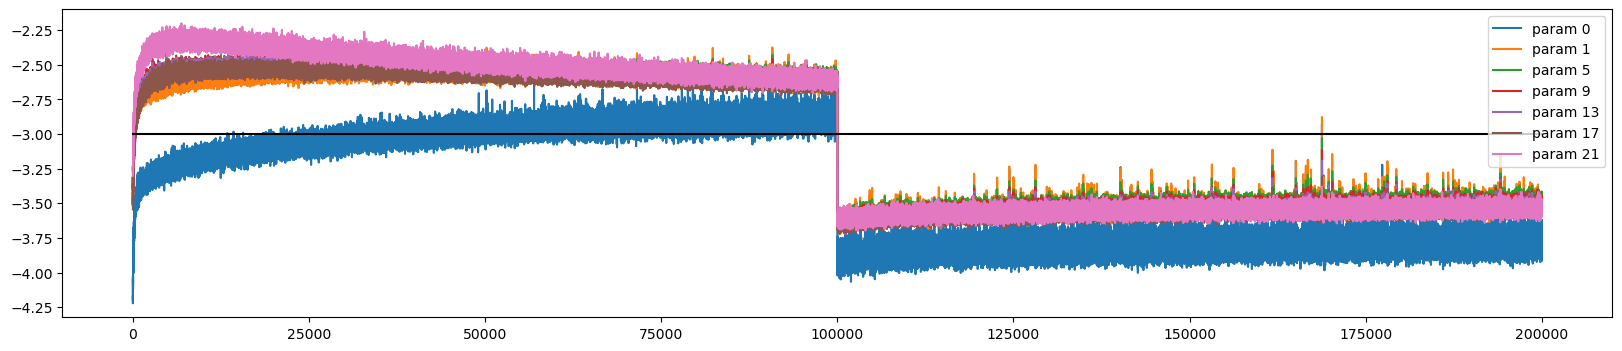

In [101]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [102]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.6747487783432007
val 2.100513219833374


In [103]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * CONTEXT_SIZE # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itoc[i] for i in out)) # decode and print the generated word

carma.
fatumick.
hiror.
xitlal.
skarlett.
rahmel.
deliah.
jareti.
nellsea.
chaiir.
kaleiyah.
brooklyne.
gates.
lillie.
addison.
elowiah.
yina.
kaelidh.
demetrici.
abeta.
